# Library Import

In [1]:
import os
import sys
import pandas as pd
from PIL import Image
import numpy as np
import time
import pickle
from IPython import display
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, datasets, utils, models
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
print("Python version", sys.version)
print("Torch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

Python version 3.9.17 (main, Jul  5 2023, 20:47:11) [MSC v.1916 64 bit (AMD64)]
Torch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118


# Bit-Wise

# Randomness control
should be applied in every cell with randomness introduced

In [70]:
import random

def global_seeds(seed_value=0):
    np.random.seed(seed_value) # random seed for the NumPy library
    torch.manual_seed(seed_value) # random seed for PyTorch's CPU-based RNG (random number generator)
    torch.cuda.manual_seed(seed_value) # random seed for PyTorch's GPU-based RNG
    torch.cuda.manual_seed_all(seed_value) # random seed to ensure multiple GPUs are synchronised
    torch.backends.cudnn.deterministic = True # set CuDNN (CUDA Deep Neural Network library) to deterministic
    torch.backends.cudnn.benchmark = False # disable the benchmark mode of CuDNN
    random.seed(seed_value) # python built-in RNG

global_seeds(42)


In [3]:
torch.backends.cudnn.deterministic = False # set CuDNN (CUDA Deep Neural Network library) to deterministic
torch.backends.cudnn.benchmark = False

In [4]:
cifar10trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
cifar10testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

Files already downloaded and verified
Files already downloaded and verified


# Data augmentation

In [5]:
class CustomCIFAR10Dataset(Dataset):
    def __init__(self, data, labels, random_crop = False, random_rotation = False, resize = False):
        self.data = data
        self.labels = labels
        transforms_list = [
            transforms.ToTensor(),  # Convert to tensor and map to range [0,1]
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25]) # Normalisation
        ]
        if resize:
            transforms_list.insert(0, transforms.Resize(resize)) # resize the image to a fixed size
        if random_rotation:
            transforms_list.insert(0, transforms.RandomRotation(random_rotation)) # Random rotation within a given angle
        if random_crop:
            transforms_list.insert(0, transforms.RandomCrop(random_crop))  # Random crop to a fixed size
        self.transform = transforms.Compose(transforms_list)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]
        image = Image.fromarray(image)
        # image = torch.from_numpy(image.transpose(2,0,1))
        image = self.transform(image)
        return image, label

# Dataset definition

In [6]:
trainset = CustomCIFAR10Dataset(cifar10trainset.data, cifar10trainset.targets, random_crop = 31, random_rotation = 10, resize = 64) # resize need to be greater than 224 for pretrained model
testset = CustomCIFAR10Dataset(cifar10testset.data, cifar10testset.targets, random_crop = False, random_rotation = False, resize = 64)

# Reproducible Check

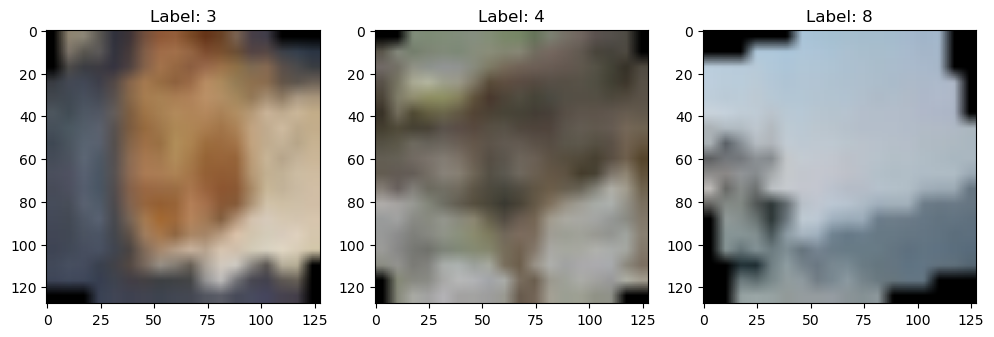

In [67]:
global_seeds(42)
example_data1, example_label1 = trainset[17]
example_data2, example_label2 = trainset[272]
example_data3, example_label3 = trainset[100]
# print(trainset.transform)
# print(example_data.shape)
image_np1 = example_data1.numpy().transpose((1, 2, 0))
image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_np1)  # permute to (height, width, channels)
plt.title(f"Label: {example_label1}")

image_np2 = example_data2.numpy().transpose((1, 2, 0))
image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
plt.subplot(132)
plt.imshow(image_np2)  # permute to (height, width, channels)
plt.title(f"Label: {example_label2}")

image_np3 = example_data3.numpy().transpose((1, 2, 0))
image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
plt.subplot(133)
plt.imshow(image_np3)  # permute to (height, width, channels)
plt.title(f"Label: {example_label3}")
plt.show()

# Dataloader

In [7]:
#global_seeds(42)
batch_size = 64
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

# Reproducible check

Input shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


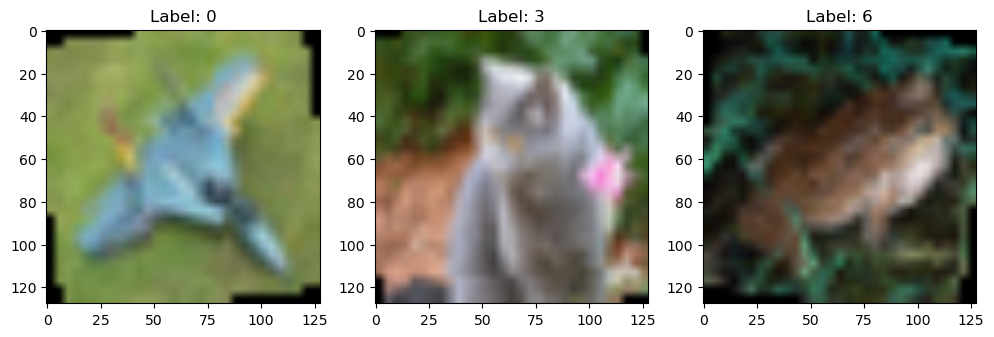

In [49]:
for batch in trainloader:
    # Unpack the batch into input data and labels (if applicable)
    inputs, labels = batch

    # Do something with the data in the current batch
    # For example, print the shapes of inputs and labels
    print(f"Input shape: {inputs.shape}")
    print(f"Labels shape: {labels.shape}")

    example_data1, example_label1 = inputs[1], labels[1]
    example_data2, example_label2 = inputs[2], labels[2]
    example_data3, example_label3 = inputs[3], labels[3]
    image_np1 = example_data1.numpy().transpose((1, 2, 0))
    image_np1 = np.uint8(((image_np1 * 0.25) + 0.5) * 255)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.imshow(image_np1)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label1}")

    image_np2 = example_data2.numpy().transpose((1, 2, 0))
    image_np2 = np.uint8(((image_np2 * 0.25) + 0.5) * 255)
    plt.subplot(132)
    plt.imshow(image_np2)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label2}")

    image_np3 = example_data3.numpy().transpose((1, 2, 0))
    image_np3 = np.uint8(((image_np3 * 0.25) + 0.5) * 255)
    plt.subplot(133)
    plt.imshow(image_np3)  # permute to (height, width, channels)
    plt.title(f"Label: {example_label3}")
    plt.show()
    break

# AlexNet

In [16]:
#pretrained AlexNet model
num_classes = 10
model = models.alexnet(weights ='AlexNet_Weights.IMAGENET1K_V1')
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model = model.cuda()
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# ResNet18

In [21]:
def reset_model():
    num_classes = 10
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model = model.cuda()
    return model
model = reset_model()

# ConvNeXT Tiny

In [32]:
def reset_model():
    num_classes = 10
    model = models.convnext_tiny(weights='IMAGENET1K_V1')
    model.classifier[2] =nn.Linear(768, num_classes)
    model = model.cuda()
    return model
model = reset_model()

In [33]:
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

# Hyperparameter setting

In [34]:
num_epochs = 16
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.5)

# Training visualisation -- display block

In [10]:
class DisplayBlock:
    def __init__(self, names, time_slot=60):
        self.start_time = time.time()
        self.time_slot = time_slot
        self.annotations = []
        self.data = {}
        for name in names:
            self.data[name] = []
    
    def update(self, data_dict):
        for key in data_dict:
            self.data[key].append(data_dict[key])
        current_time = time.time() - self.start_time
        idx = len(self.data[key]) -1
        if len(self.annotations) == 0:
            if current_time > self.time_slot:
                self.annotations.append((idx, current_time))
        elif current_time - (self.annotations[-1][1]//self.time_slot)*self.time_slot > self.time_slot:
            self.annotations.append((idx, current_time))
    
    def draw(self):
        all_keys = list(self.data.keys())
        fig, ax = plt.subplots(nrows=1, ncols=len(all_keys))
        fig.set_figwidth(20)
        for idx in range(len(all_keys)):
            ax[idx].plot(self.data[all_keys[idx]])
            ax[idx].set_title(all_keys[idx])
            for an in self.annotations:
                ax[idx].annotate(f'{int(an[1])}s', xy=(an[0], self.data[all_keys[idx]][an[0]]),
                    xytext=(0, -40), textcoords="offset points",
                    va="center", ha="left",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
        display.clear_output(wait=True)
        plt.show()

# Training process

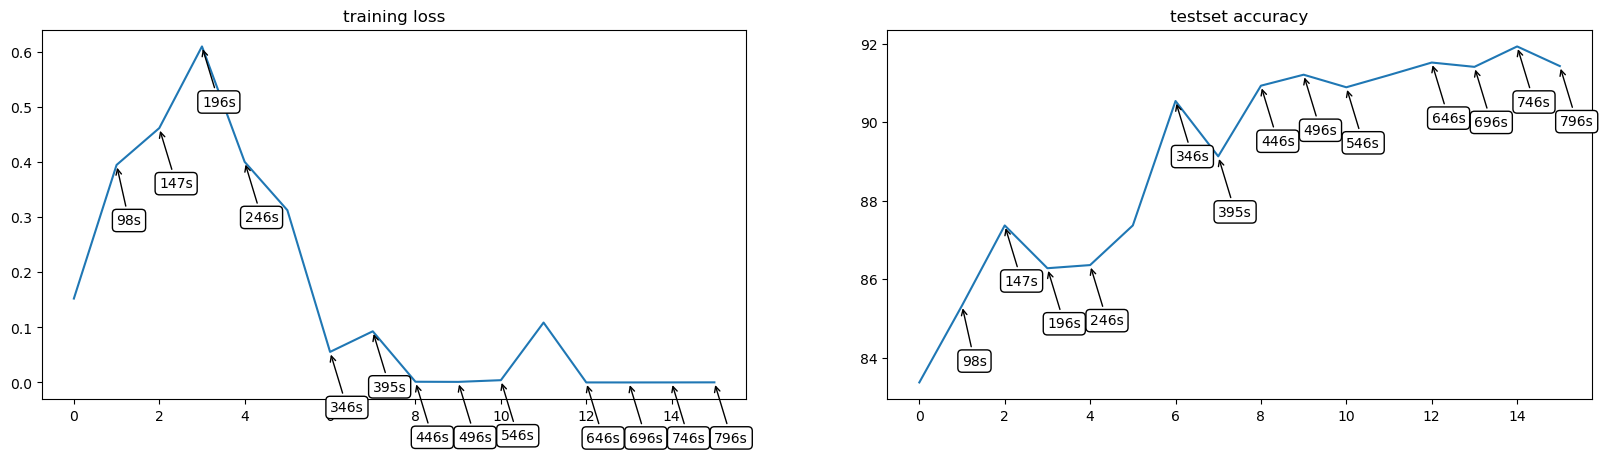

Epoch [16/16] - Training Loss: 0.00861, Testset Accuracy: 91.43%, Learning Rate: 0.000125
Training finished


In [35]:
#global_seeds(42)
db = DisplayBlock(['training loss', 'testset accuracy'], time_slot=60)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels, in trainloader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images).cuda()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()                
        running_loss += loss.item()
    
    scheduler.step()
    # obtain the current learning rate 
    current_lr = optimizer.param_groups[0]['lr']
    # print the loss and the learning rate
    # print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainingloader)}, Learning Rate: {current_lr}")
    print ("Training complete")

    # Evaluation on testset
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # find the index with the highest probability
            predicted = outputs.argmax(dim=1)
            # match the prediction with labels
            comparison = predicted == labels
            total_predictions += predicted.size(0)
            correct_predictions += comparison.sum()
    trainingloss = loss.item()
    testset_accuracy = (100 * correct_predictions / total_predictions).cpu()
    display.clear_output(wait=True)
    db.update({'training loss': trainingloss, 'testset accuracy': testset_accuracy})
    db.draw()
    print(f"Epoch [{epoch+1}/{num_epochs}] - Training Loss: {(running_loss / len(trainloader)):.5f}, Testset Accuracy: {testset_accuracy:.2f}%, Learning Rate: {current_lr}")


print("Training finished")

In [12]:
#global_seeds(42)
True_label = []
predicted_label = []
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        # find the index with the highest probability
        predicted = outputs.argmax(dim=1)

        True_label.extend(labels.cpu().numpy())
        predicted_label.extend(predicted.cpu().numpy())

# Accuracy
accuracy = accuracy_score(True_label, predicted_label)
print(f'Accuracy: {accuracy:.2f}')

# Precision
precision = precision_score(True_label, predicted_label, average='weighted')
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(True_label, predicted_label, average='weighted')
print(f'Recall: {recall:.2f}')

# F1 Score
f1 = f1_score(True_label, predicted_label, average='weighted')
print(f'F1 Score: {f1:.2f}')

# Classification Report
class_report = classification_report(True_label, predicted_label)
print('Classification Report:')
print(class_report)

Accuracy: 0.89
Precision: 0.89
Recall: 0.89
F1 Score: 0.89
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      1000
           1       0.92      0.95      0.94      1000
           2       0.89      0.84      0.87      1000
           3       0.70      0.84      0.77      1000
           4       0.90      0.89      0.89      1000
           5       0.83      0.79      0.81      1000
           6       0.93      0.90      0.91      1000
           7       0.94      0.91      0.92      1000
           8       0.95      0.93      0.94      1000
           9       0.95      0.87      0.91      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



# Execution-exact

Hyperparameter configuration

In [36]:
num_iter = 5
num_epochs = 16
learning_rate = 0.001

# Monte Carlo Method for random sampling in training process
The model is defined in the function reset_model()

num_iter is the size of sample

other parameters are all reset through each trial

The optimiser and scheduler is defined in the following code

In [37]:
sample_output = []
for iterations in range(num_iter):
    model = reset_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,8,12], gamma=0.5)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels, in trainloader:
            images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images).cuda()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()                
            running_loss += loss.item()
        
        scheduler.step()
        # obtain the current learning rate 
        # current_lr = optimizer.param_groups[0]['lr']
        # print the loss and the learning rate
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(trainloader)}")
    print (f"{iterations+1} Training complete")
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # find the index with the highest probability
            predicted = outputs.argmax(dim=1)
            # match the prediction with labels
            comparison = predicted == labels
            total_predictions += predicted.size(0)
            correct_predictions += comparison.sum()
    trainingloss = loss.item()
    testset_accuracy = (100 * correct_predictions / total_predictions).cpu()
    print(f"Testset Accuracy: {testset_accuracy:.2f}%")
    sample_output.append(testset_accuracy)

Epoch [1/16] - Loss: 0.7588326149355725
Epoch [2/16] - Loss: 0.43314758389044905
Epoch [3/16] - Loss: 0.3416945207244752
Epoch [4/16] - Loss: 0.2840851542761411
Epoch [5/16] - Loss: 0.23805733566717877
Epoch [6/16] - Loss: 0.2114201338242387
Epoch [7/16] - Loss: 0.09523274406821698
Epoch [8/16] - Loss: 0.0645935757227404
Epoch [9/16] - Loss: 0.0352340333270626
Epoch [10/16] - Loss: 0.02560968243911037
Epoch [11/16] - Loss: 0.026802947021299695
Epoch [12/16] - Loss: 0.02331960751591926
Epoch [13/16] - Loss: 0.01216944386098122
Epoch [14/16] - Loss: 0.010991983627188237
Epoch [15/16] - Loss: 0.009829909698905596
Epoch [16/16] - Loss: 0.01072914361886242
1 Training complete
Testset Accuracy: 90.80%
Epoch [1/16] - Loss: 0.643037879806193
Epoch [2/16] - Loss: 0.40634847194185036
Epoch [3/16] - Loss: 0.3316771170157758
Epoch [4/16] - Loss: 0.27874596794243056
Epoch [5/16] - Loss: 0.24793788915037956
Epoch [6/16] - Loss: 0.20914784241277162
Epoch [7/16] - Loss: 0.09214688243839861
Epoch [8/16

KeyboardInterrupt: 

# Calculate the 95% CI from the result of the Monte Carlo Method

In [39]:
sample_mean = np.mean(sample_output)
sample_std = np.std(sample_output)
sample_size = len(sample_output)
Z = 1.96
CI_lowerbound = sample_mean - Z*sample_std/np.sqrt(sample_size)
CI_upperbound = sample_mean + Z*sample_std/np.sqrt(sample_size)
print(f"The 95% confidence interval = [{CI_lowerbound:.2f},{CI_upperbound:.2f}]")

The 95% confidence interval = [91.03,91.97]
